## 26. DCGAN
単純なフィードフォワードネットワークではなく、畳み込みニューラルネットワークを用いるネットワークを、  
**深層畳み込みGAN(DCGAN: Deep Convolutional GAN)**と呼ぶ。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

#### 生成器
ベクトルを入力とし、それを画像サイズに拡張していく。  
ここで、**転置畳み込み**という手法を使うことで、幅と高さを拡大する一方で深度を小さくしていく。  
生成器におけるステップは、  
1. ノイズベクトルを作り、全結合層を通すことで7×7×256のテンソルに変換する
2. 転置畳み込み層により、7×7×256のテンソルを14×14×256のテンソルにする
3. バッチ正規化を行い、Leakly ReLUを適用
4. 転置畳み込み層により、今度は14×14×256のテンソルを14×14×64のテンソルに変換する
5. バッチ正規化を行い、Leakly ReLUを行う
6. 転置畳み込みを行い、14×14×64のテンソルを28×28×1のテンソルに変換する
7. tanh関数を適用

In [9]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    return model

#### 識別器
識別器のステップは、
1. 畳み込み層により、28×28×1の入力画像を14×14×32のテンソルに変換
2. Learky ReLUに適用
3. 畳み込み層を使って、14×14×32のテンソルを7×7×64のテンソル
4. バッチ正規化とLeaky ReLUを適用
5. 畳み込み層を使って、7×7×64のテンソルを3×3×128のテンソルに変換
6. バッチ正規化とLeaky ReLUを適用
7. 3×3×128のテンソルを一列に並べて3×3×128=1152次元のベクトルにする
8. 全結合層を使い結果をまとめ、シグモイド関数を通して本物かどうかの確率を計算する

In [10]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

#### DCGAN

In [18]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
generator = build_generator(z_dim)

# 生成器の訓練時は、識別器のパラメータは定数にする
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

#### 学習

In [19]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    
    X_trian = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1))
    
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # --------------------
        # 識別器の学習
        # --------------------
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # --------------------
        # 生成器の学習
        # --------------------
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0*accuracy, g_loss))
            
            sample_images(generator)

In [14]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

50 [D loss: 0.001437, acc.: 100.00%] [G loss: 0.583876]
100 [D loss: 0.000263, acc.: 100.00%] [G loss: 0.323935]
150 [D loss: 0.000164, acc.: 100.00%] [G loss: 0.228159]
200 [D loss: 0.000169, acc.: 100.00%] [G loss: 0.189042]
250 [D loss: 0.000143, acc.: 100.00%] [G loss: 0.172062]
300 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.162989]
350 [D loss: 0.000161, acc.: 100.00%] [G loss: 0.140572]
400 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.125654]
450 [D loss: 0.000162, acc.: 100.00%] [G loss: 0.105978]
500 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.086408]
550 [D loss: 0.000156, acc.: 100.00%] [G loss: 0.078263]
600 [D loss: 0.000102, acc.: 100.00%] [G loss: 0.066701]
650 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.068464]
700 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.063365]
750 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.052666]
800 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.047961]
850 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.042691]
900 [D loss: 0.000018, acc.: 100

<ipython-input-14-b55c1b881c14>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(image_grid_rows,


1100 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.029855]
1150 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.026654]
1200 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.024493]
1250 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.023041]
1300 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.020130]
1350 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.018449]
1400 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.017098]
1450 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.015856]
1500 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.014717]
1550 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.014327]
1600 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.013738]
1650 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.013551]
1700 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.012349]
1750 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.011324]
1800 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.010454]
1850 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.009437]
1900 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.008537]
1950 [D loss: 

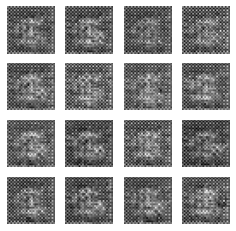

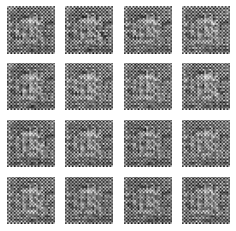

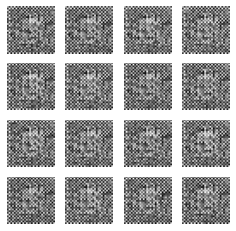

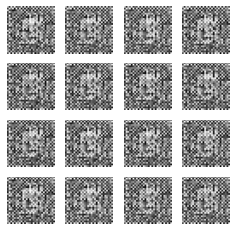

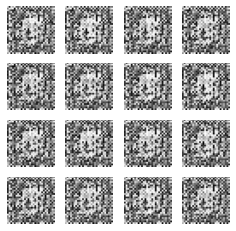

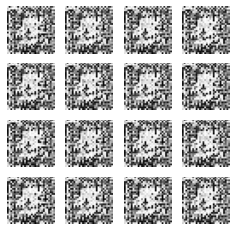

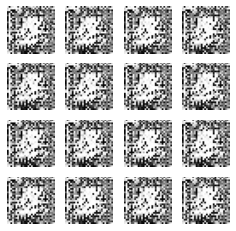

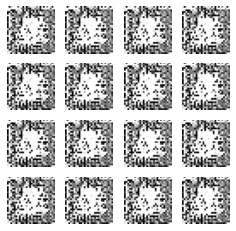

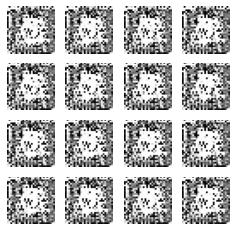

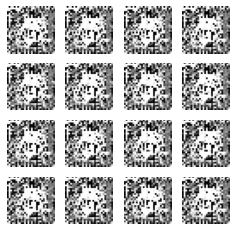

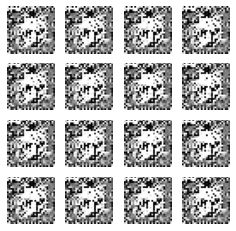

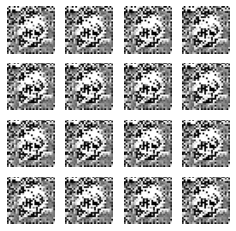

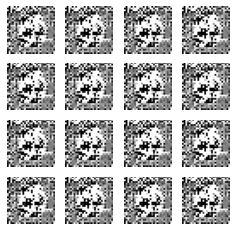

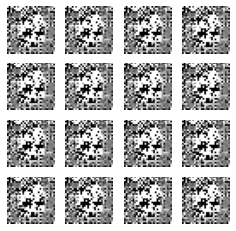

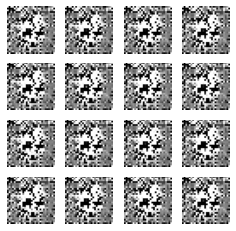

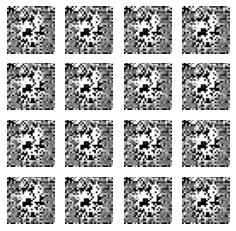

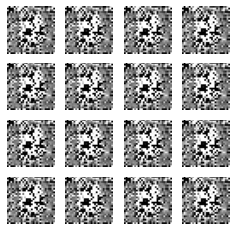

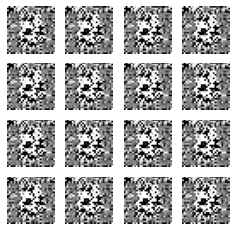

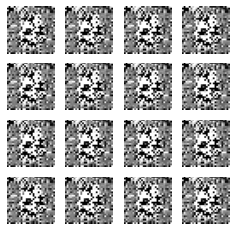

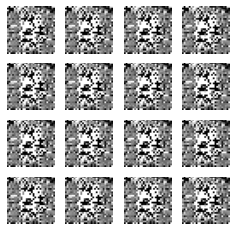

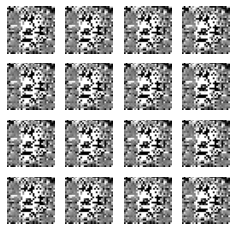

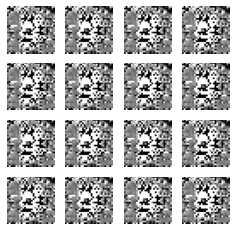

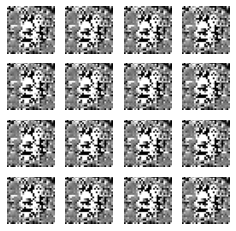

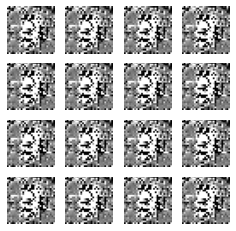

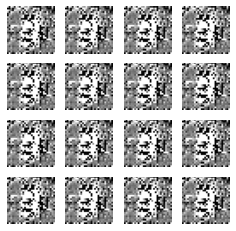

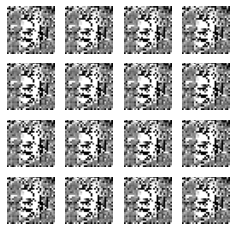

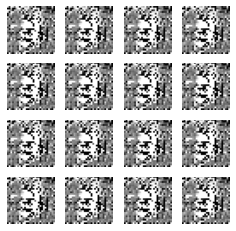

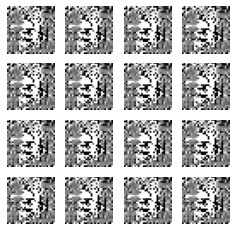

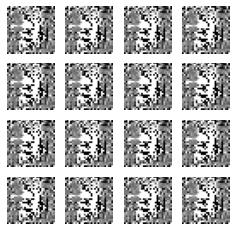

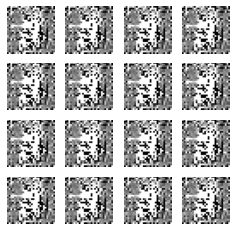

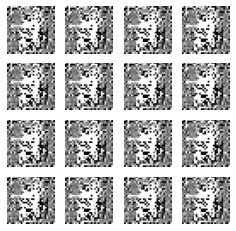

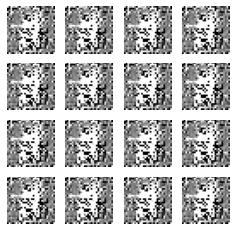

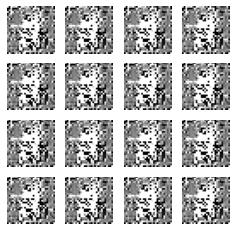

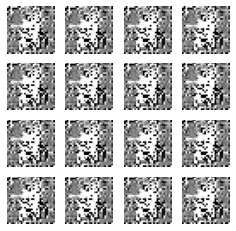

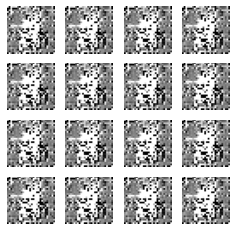

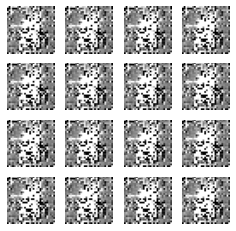

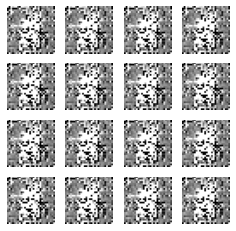

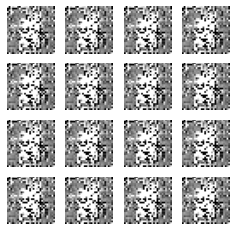

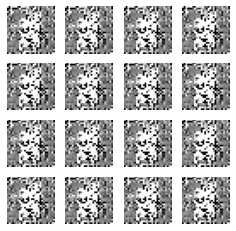

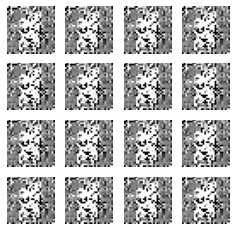

In [20]:
iterations = 2000
batch_size = 128
sample_interval = 50

train(iterations, batch_size, sample_interval)